#                                                    Case Study
<hr style="border: 4px solid black;" />

![title](theme.png)

<h2>Problem Statement</h2>
<hr style="border: 1px solid black;" />


This is kaggle competition problem .in this problem we have given historical sales data for 45 Walmart stores located in different regions. Each store contains many departments, and participants must project the sales for each department in each store. <br>
This data is collected regarding the type of customers and their preference regarding purchasing or buying of products ,sales rate at weekdays or weekends. All the types of Sales data is taken as input and we need to predict output of sales.<br>
This data is of supervised learning and time series type problem .in this output of sales is dependent on different input features of sales like store number ,department number, is_holiday, year ,months etc.the best feature is  that weekend holidays, months, store number etc. which involve the time series also.<br>
https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/overview/evaluation

<h2>Problem Evaluation</h2>
<hr style="border: 1px solid black;" />


This Problem is evaluated on the weighted mean absolute error (WMAE):

                       WMAE=1∑wi∑i=1nwi|yi−y^i|
where

n is the number of rows<br>
y^i is the predicted sales<br>
yi is the actual sales<br>
wi are weights. w = 5 if the week is a holiday week, 1 otherwise

![title](sub.png)

<h1>Submission score criteria</h1>
<hr style="border: 1px solid black;" />

![title](Submission1.png)

There are total 688 submission of this problem and according to criteria of acceptence of case study is our submission score should be under top 10%

![title](Submission.png)
last 10% submisson score is 2850,so our score should be under 2850

<h3>importing all the libraries</h3>
<hr style="border: 1px solid black;" />

In [1]:
#importing all the libraries
import numpy as np
import pandas as pd

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
#import lightgbm as lgb 
from sklearn.ensemble import GradientBoostingRegressor 
import matplotlib.pyplot as plt
import seaborn as sns
# The current ver  sion of seaborn generates a bunch of warnings that we'll ignore
import warnings 
warnings.filterwarnings("ignore")
sns.set_style('darkgrid')
import os
import time
from datetime import datetime



import pendulum


#from xgboost import XGBRegressor
import pickle
from pandas import to_datetime
import lightgbm 
 
#from fbprophet import Prophet

In [2]:
#reading a csv file
feat=pd.read_csv('features.csv')
store=pd.read_csv('stores.csv')
sales_train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
sales_test = pd.read_csv('test.csv')


<h6>We have given 4 csv files ,so we are reading all 4 csv files

<h1>Feature engineering

<h5>In first step of FE, we will merge the train ,features,store dataframe together ,so that we will get single dataframe in which all feautres of dataframe together stored

In [3]:
#here we merging the train ,features,store dataframe together
train_merge=sales_train.merge(store,how='left')
train=train_merge.merge(feat,how='left')

In [4]:
#here we merging the test,features,store dataframe together
test_merge=test.merge(store,how='left')  
test=test_merge.merge(feat,how='left')

In [5]:
# Concatenating train & test
train['train_or_test'] = 'train'
test['train_or_test'] = 'test'
merged_datframe = pd.concat([train,test], sort=False)
print('Combined merged_df shape:{}'.format(merged_datframe.shape))

Combined merged_df shape:(536634, 17)


In [6]:
merged_datframe.isnull().mean() * 100

Store             0.000000
Dept              0.000000
Date              0.000000
Weekly_Sales     21.441802
IsHoliday         0.000000
Type              0.000000
Size              0.000000
Temperature       0.000000
Fuel_Price        0.000000
MarkDown1        50.507049
MarkDown2        63.162043
MarkDown3        54.843338
MarkDown4        55.809173
MarkDown5        50.339337
CPI               7.111365
Unemployment      7.111365
train_or_test     0.000000
dtype: float64

In [7]:
merged_datframe.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,train_or_test
115059,45,98,2013-06-28,NaN,False,B,118221,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,test
115060,45,98,2013-07-05,NaN,False,B,118221,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,test
115061,45,98,2013-07-12,NaN,False,B,118221,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,test
115062,45,98,2013-07-19,NaN,False,B,118221,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,test
115063,45,98,2013-07-26,NaN,False,B,118221,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,test


In [8]:
# here we are Sorting the dataframe by store then Dept then date
merged_datframe = merged_datframe.sort_values(by=['Store','Dept','Date'], axis=0).reset_index().drop(columns='index')

In [9]:
# here we use One-hot-encode for  "Type" categorical variables 
merged_datframe = pd.get_dummies(merged_datframe, columns=['Type'])


In [10]:
# here we use Label-encoder for  "IsHoliday" categorical variables 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
merged_datframe['IsHoliday'] = le.fit_transform(merged_datframe['IsHoliday'])

In [11]:
# 

def Superbowl(x):
  if (x == '2010-02-12') | (x == '2011-02-11') | (x == '2012-02-10') | (x == '2013-02-08'):
    return 1
  else:
    return 0

def Laborday(x):
  if (x == '2010-09-10') | (x == '2011-09-09') | (x == '2012-09-07') | (x == '2013-09-06'):
    return 1
  else:
    return 0

def Thanksgiving(x):
  if (x == '2010-11-26') | (x == '2011-11-25') | (x == '2012-11-23') | (x == '2013-11-29'):
    return 1
  else:
    return 0

def Christmas(x):
  if (x == '2010-12-31') | (x == '2011-12-30') | (x == '2012-12-28') | (x == '2013-12-27'):
    return 1
  else:
    return 0

merged_datframe['IsSuperbowl'] = merged_datframe['Date'].apply(lambda x: Superbowl(x)) # adding the Issuperbowl feature
merged_datframe['IsLaborday'] = merged_datframe['Date'].apply(lambda x: Laborday(x))
merged_datframe['IsThanksgiving'] = merged_datframe['Date'].apply(lambda x: Thanksgiving(x))
merged_datframe['IsChristmas'] = merged_datframe['Date'].apply(lambda x: Christmas(x))

<h6>here we are Creating new features ,their names are  - "IsSuperbowl", "IsLaborday", "IsThanksgiving", "IsChristmas" .in this feature we create four new columns in which we creating  some special holidays like laborday,superbowl etc .if these dataes are available in our data then it will be 1 otherwise as 0

In [12]:
# Extract features from "Date" feature
merged_datframe['WeekofMonth'] = merged_datframe['Date'].apply(lambda x: pendulum.parse(x).week_of_month) # here we are fetching week of month for date
merged_datframe['Date'] = pd.to_datetime(merged_datframe['Date']) #Here we are converting the date column into datetime feature
merged_datframe['Year'] = merged_datframe['Date'].dt.year         #Here we are extracting the date from  date column
merged_datframe['Month'] = merged_datframe['Date'].dt.month       #Here we are extracting the month from  date column
merged_datframe['Week'] = merged_datframe['Date'].dt.week         #Here we are extracting week from  date column
merged_datframe['Day'] = merged_datframe['Date'].dt.day           #Here we are extracting day from  date column

In [13]:
# Features constructed from previous sales values
#https://www.kaggle.com/abhilashawasthi/feature-engineering-lgb-model

#this function will return the value of aggreagrate function that we pass like(mean ,minimum,maximum ,median of weekly sale)
def create_sales_agg_monthwise_features(df, gpby_cols, target_col, agg_funcs):
    gpby = df.groupby(gpby_cols)
    newdf = df[gpby_cols].drop_duplicates().reset_index(drop=True)
    for agg_name, agg_func in agg_funcs.items():
        aggdf = gpby[target_col].agg(agg_func).reset_index()
        aggdf.rename(columns={target_col:'Monthly_Sales_'+agg_name}, inplace=True)
        newdf = newdf.merge(aggdf, on=gpby_cols, how='left')
    return newdf

# this function will return last 52 day monthly sale value for every rows4
#https://www.geeksforgeeks.org/python-pandas-dataframe-shift/
def last_52_days(df, gpby_cols, target_col, lags):
    gpby = df.groupby(gpby_cols)
    for i in lags:
    
        df['_'.join([target_col, 'lag', str(i)])] = gpby[target_col].shift(i).values 
    return df

##this function will return exponential mean of  last 52 day monthly sale value for every rows
#https://www.datacamp.com/community/tutorials/moving-averages-in-pandas
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
def exponential_mean_last_52_days(df, gpby_cols, target_col, alpha=[0.9], shift=[1]):
    gpby = df.groupby(gpby_cols)
    for a in alpha:
        for s in shift:
            df['_'.join([target_col, 'lag', str(s), 'ewm', str(a)])] = gpby[target_col].apply(lambda x: x.shift(s).ewm(alpha=0.95).mean())
    return df

In [14]:
# creating sales lag features 
import numpy as np
merged_new_datframe = last_52_days(merged_datframe, gpby_cols=['Store','Dept'], 
                                       target_col='Weekly_Sales', lags=[52])

# creating ewm features 
merged_new_datframe= exponential_mean_last_52_days(merged_new_datframe, gpby_cols=['Store','Dept'], 
                                       target_col='Weekly_Sales', alpha=[0.95, 0.9, 0.8, 0.7, 0.6, 0.5],
                                       shift=[52])

# creating sales monthwise aggregated values
df= create_sales_agg_monthwise_features(merged_new_datframe.loc[~(merged_new_datframe.train_or_test=='test'), :], gpby_cols=['Store','Dept', 'Month'], 
                                               target_col='Weekly_Sales', 
                                             agg_funcs={'mean':np.mean, 
                                              'median':np.median, 'max':np.max, 
                                              'min':np.min, 'std':np.std})
# # Joining agg_df with merged_df_new
merged_new_datframe = merged_new_datframe.merge(df, on=['Store','Dept', 'Month'], how='left')

<h6>Here we creating some new features like last 52 days sale value,last 52 days mean sales value,mean ,median,minimum ,maximum value of sales etc

In [15]:
#here we are dropping the unnecessary columns
merged_new_datframe = merged_new_datframe.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis=1)


In [16]:
#now we are seperating the train and test data
# Final train and test datasets
train = merged_new_datframe.loc[merged_new_datframe.train_or_test=='train', :]
test = merged_new_datframe.loc[merged_new_datframe.train_or_test=='test', :]
print('Train shape:{}, Test shape:{}'.format(train.shape, test.shape))

Train shape:(421570, 35), Test shape:(115064, 35)


In [17]:
train.columns#printing all new column features of our train dataframe

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Size',
       'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'train_or_test',
       'Type_A', 'Type_B', 'Type_C', 'IsSuperbowl', 'IsLaborday',
       'IsThanksgiving', 'IsChristmas', 'WeekofMonth', 'Year', 'Month', 'Week',
       'Day', 'Weekly_Sales_lag_52', 'Weekly_Sales_lag_52_ewm_0.95',
       'Weekly_Sales_lag_52_ewm_0.9', 'Weekly_Sales_lag_52_ewm_0.8',
       'Weekly_Sales_lag_52_ewm_0.7', 'Weekly_Sales_lag_52_ewm_0.6',
       'Weekly_Sales_lag_52_ewm_0.5', 'Monthly_Sales_mean',
       'Monthly_Sales_median', 'Monthly_Sales_max', 'Monthly_Sales_min',
       'Monthly_Sales_std'],
      dtype='object')

In [17]:
train.to_csv("final_train.csv",index=False)
test.to_csv("final_test.csv",index=False)

<h1>Visualisation

<h3>Univariate analysis

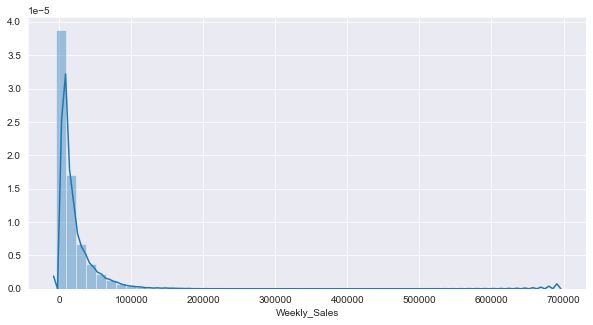

In [36]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(10,5))
sns.distplot(train['Weekly_Sales'])

Here we can observe that weekely sales plot is look like right side skew distribution and most of the sales lies between 0 to 10 thosand and there are so less sales values which lies between 60 to 70 thousand

<h3>Multivariate Analysis
 
    

[Text(0.5, 1.0, 'stotres vs Weekly_sales at holidays')]

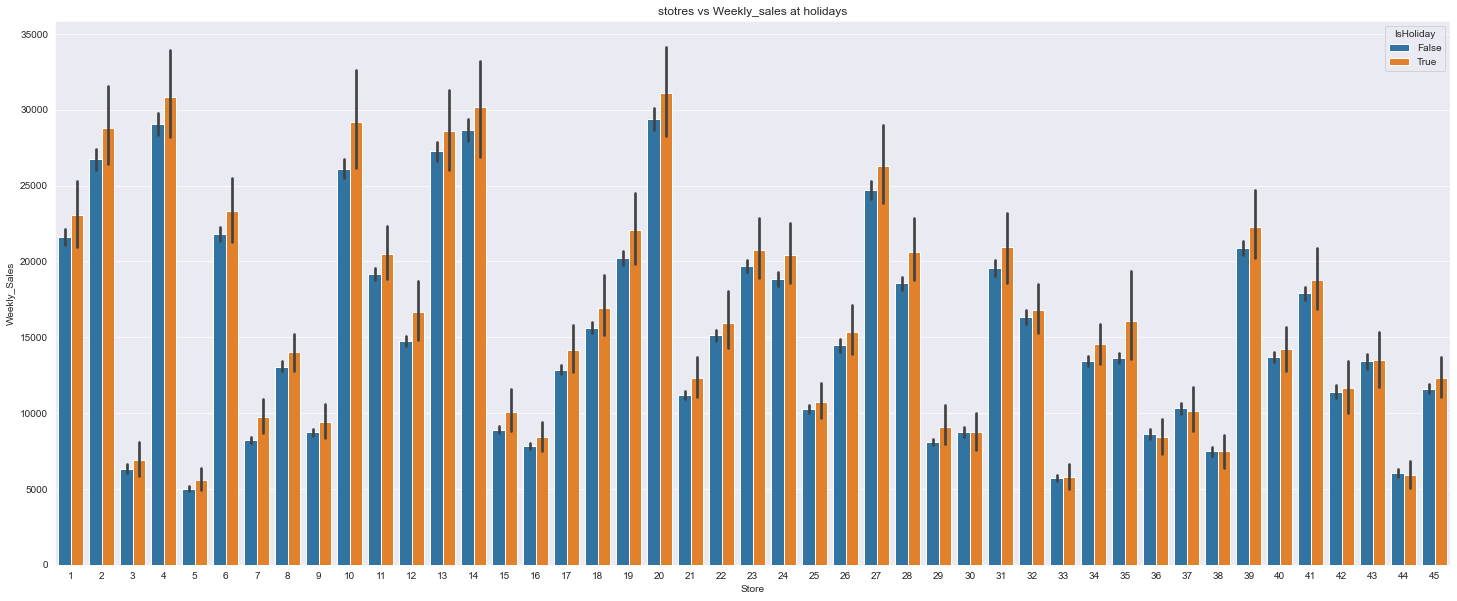

In [14]:
#stores vs Weekly_sales at holidays
import seaborn as sns
plt.figure(figsize=(25,10))

sns.barplot(x='Store', y='Weekly_Sales', data=merged_datframe,hue="IsHoliday").set(title='stores vs Weekly_sales at holidays')


Here we observe that at holidays only store number (4,14,20) have highest sale and their sales value is greater then 30000 and remaning stores have sales valueless then 22000 <br>
only store number (5 ,33,44) have less sale value at holidays ,their sales value is less then 7000<br>
We observe that at holidays most of the stores have sales values are greater then normal days sales

[Text(0.5, 1.0, 'Store_Type vs Weekly_sales at Holidays')]

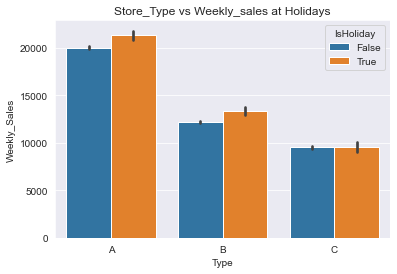

In [7]:
#Store_Type vs Weekly_sales at Holidays
sns.barplot(x='Type', y='Weekly_Sales', data=merged_datframe,hue="IsHoliday").set(title='Store_Type vs Weekly_sales at Holidays')

Here we observe that at Holidays Store type A have highest weekely sale then type B and C<br>
We also observe on weekdays store type A have highest sales then another store type<br>
We also observe that store type c have less sale at weekdays and holidays both

[Text(0.5, 1.0, 'stores vs Weekly_sales at Thanksgiving day')]

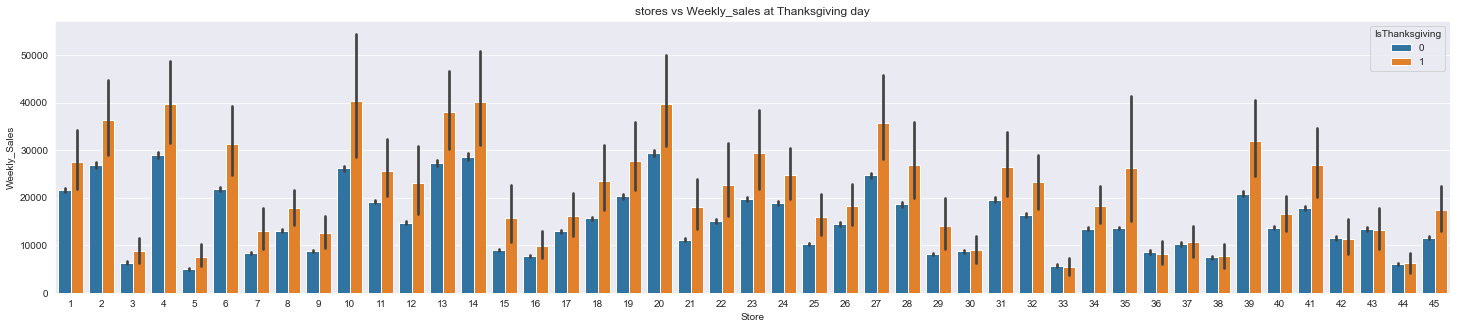

In [41]:
#stores vs Weekly_sales at Thanksgiving day
import seaborn as sns
plt.figure(figsize=(25,5))

sns.barplot(x='Store', y='Weekly_Sales', data=merged_datframe,hue="IsThanksgiving").set(title='stores vs Weekly_sales at Thanksgiving day')


[Text(0.5, 1.0, 'stores vs Weekly_sales at Thanksgiving day')]

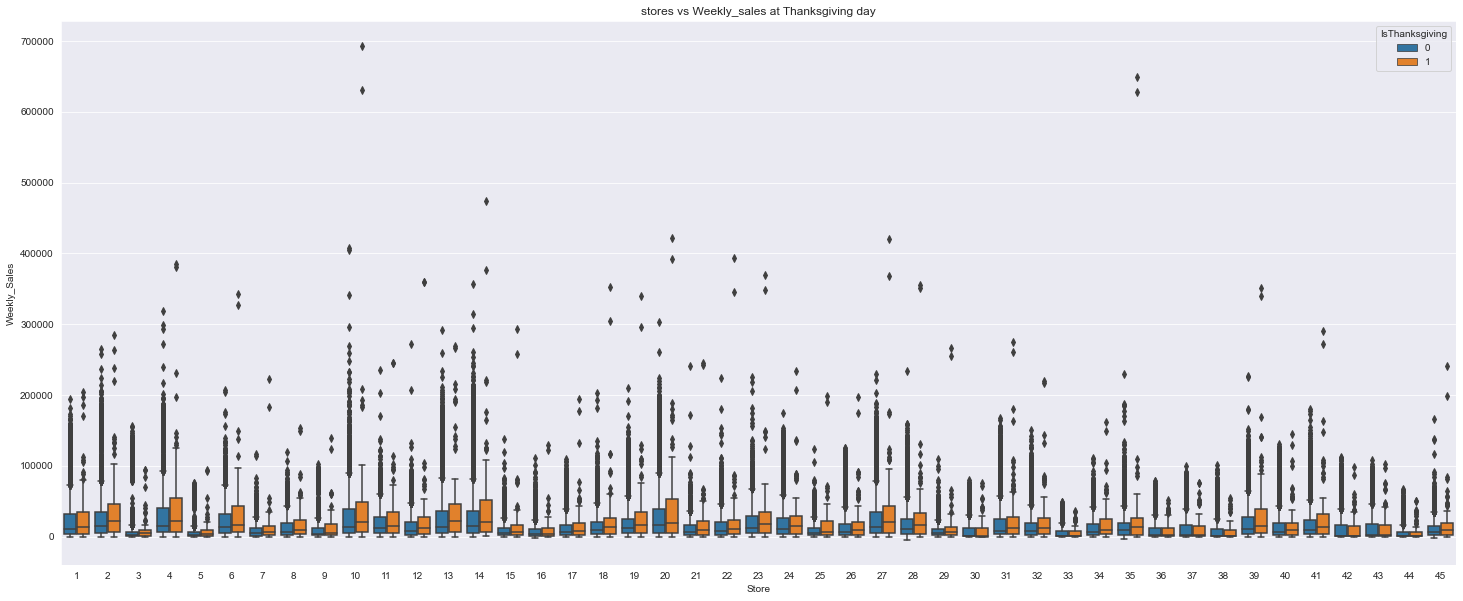

In [39]:
#stores vs Weekly_sales at Thanksgiving day
import seaborn as sns
plt.figure(figsize=(25,10))

sns.boxplot(x='Store', y='Weekly_Sales', data=merged_datframe,hue="IsThanksgiving").set(title='stores vs Weekly_sales at Thanksgiving day')


We observe that at thanksgiving day store no (2,4,6,10,13,14,20) have maximum sales and their sales values greater then 30000 and rest of the stores at Non thanksgiving day their sales values less then thanksgiving day sales<br>
store number 10 have outlier at that day whose value is greater then 60 lakh <br>
whereas store no (3,5,33) have lowest sale and their sales values approx 5000<br>


[Text(0.5, 1.0, 'stores vs Weekly_sales at Superbowl day')]

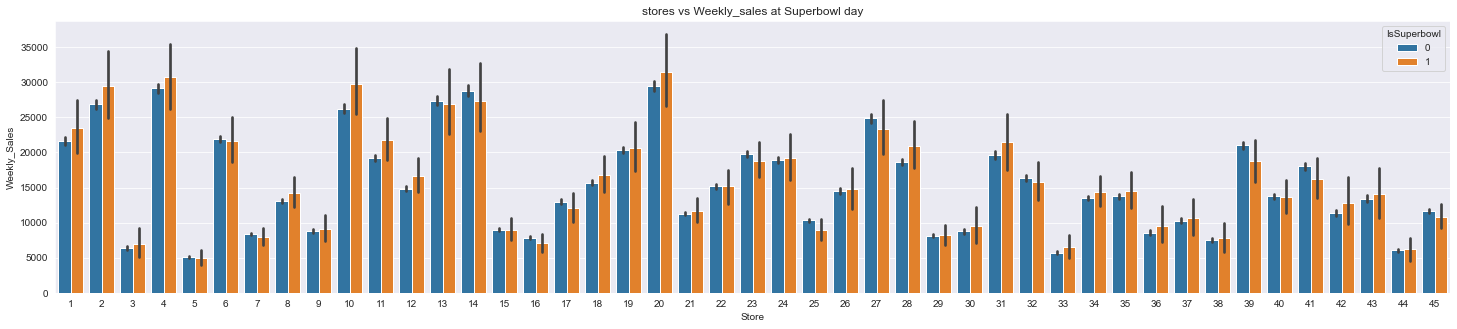

In [33]:
#stores vs Weekly_sales at Superbowl day
import seaborn as sns
plt.figure(figsize=(25,5))

sns.barplot(x='Store', y='Weekly_Sales', data=merged_datframe,hue="IsSuperbowl").set(title='stores vs Weekly_sales at Superbowl day')


[Text(0.5, 1.0, 'stores vs Weekly_sales at Superbowl day')]

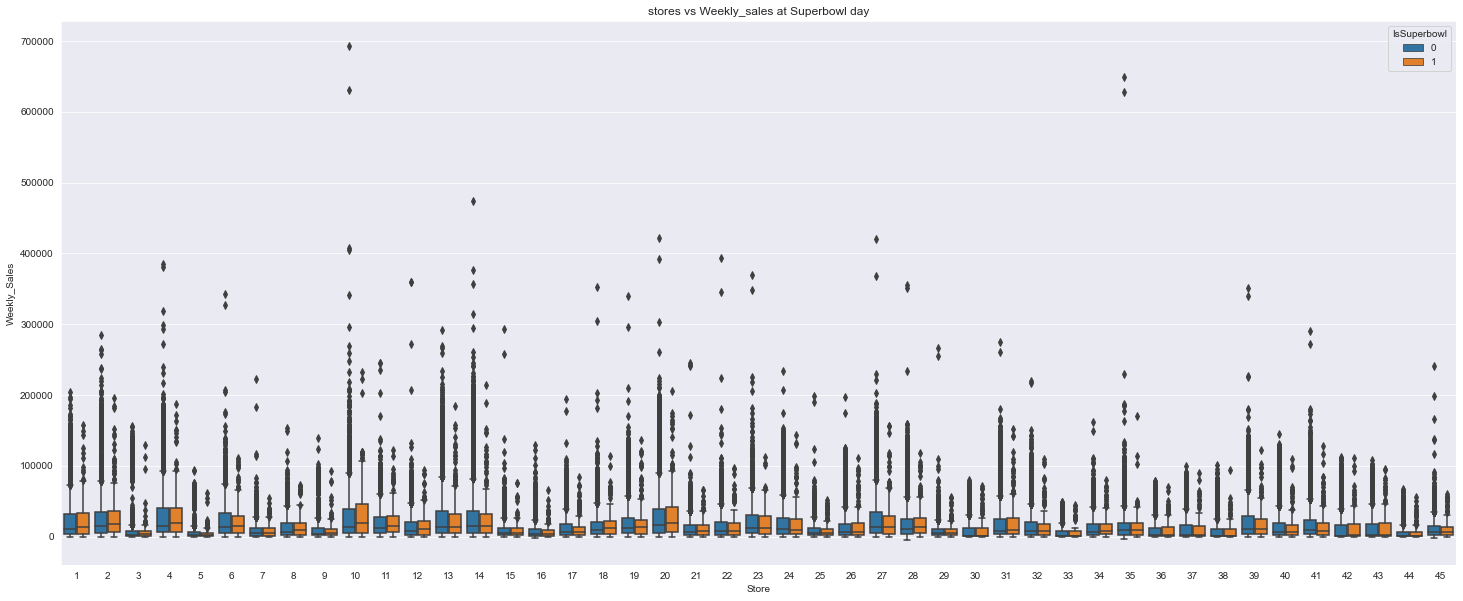

In [40]:
#stores vs Weekly_sales at Superbowl day
import seaborn as sns
plt.figure(figsize=(25,10))

sns.boxplot(x='Store', y='Weekly_Sales', data=merged_datframe,hue="IsSuperbowl").set(title='stores vs Weekly_sales at Superbowl day')


We observe that at Superbowl day store no (4,10,20) have maximum sales and their sales values greater then 30000<br>
whereas store no (3,5) have lowest sale and their sales values approx 1000.<br>
On the other days most of the stores sales values always less superbowl day sale's value
There are also some stores like store no(13,14,30 etc) whose sales values are greater then Superbowl day

[Text(0.5, 1.0, 'stores vs Weekly_sales at Laborday')]

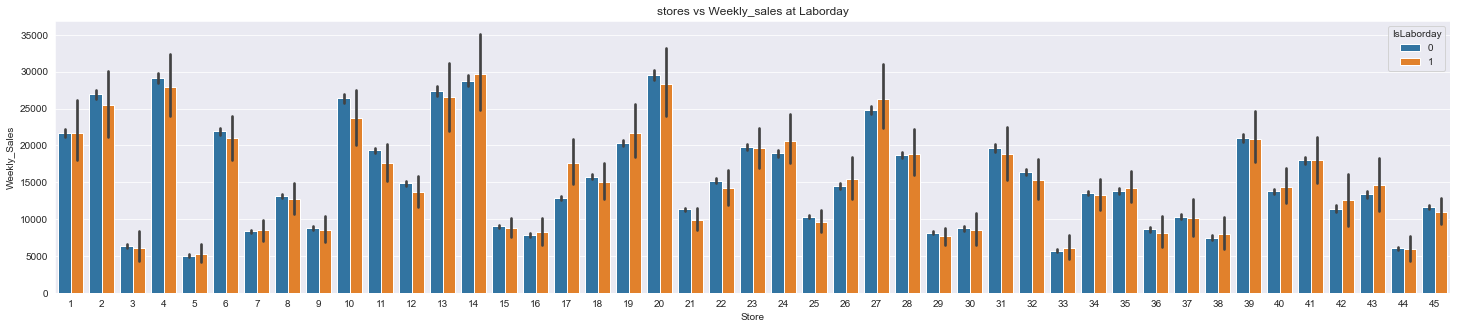

In [35]:
#stores vs Weekly_sales at Laborday
import seaborn as sns
plt.figure(figsize=(25,5))

sns.barplot(x='Store', y='Weekly_Sales', data=merged_datframe,hue="IsLaborday").set(title='stores vs Weekly_sales at Laborday')


[Text(0.5, 1.0, 'stores vs Weekly_sales at Laborday')]

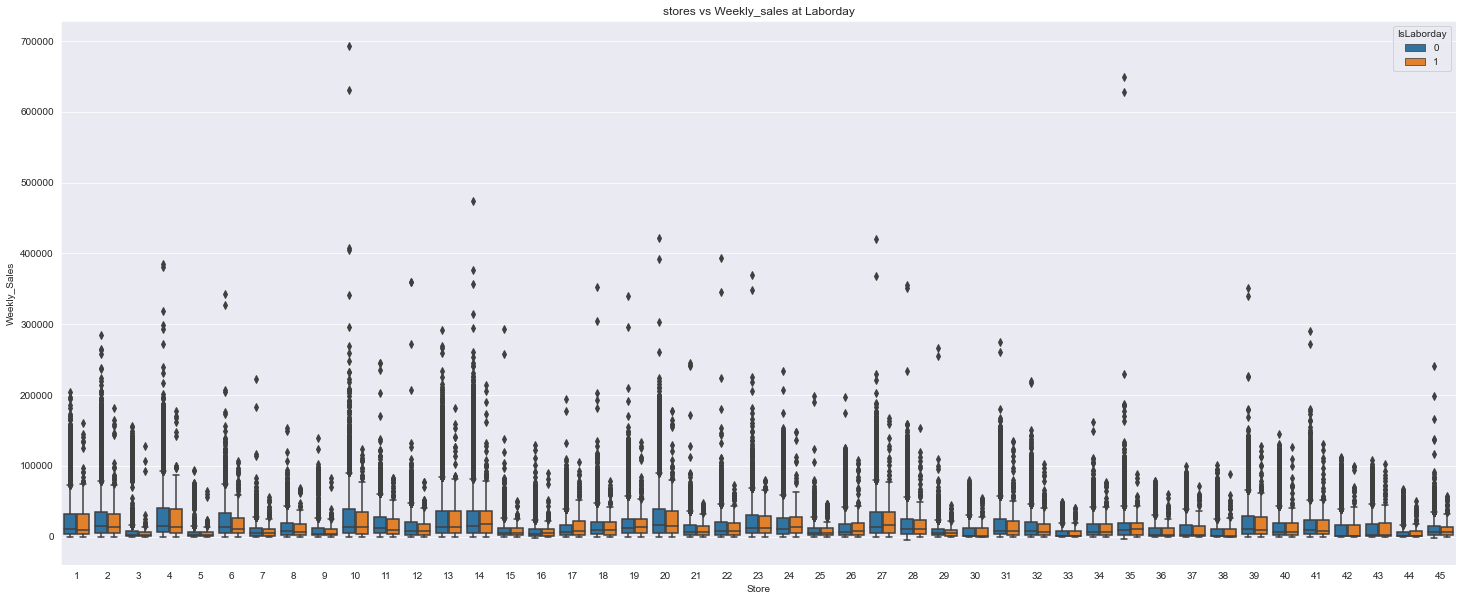

In [38]:
#stores vs Weekly_sales at Laborday
import seaborn as sns
plt.figure(figsize=(25,10))

sns.boxplot(x='Store', y='Weekly_Sales', data=merged_datframe,hue="IsLaborday").set(title='stores vs Weekly_sales at Laborday')


We observe that at Labour day store no (4,14,20,27) have maximum sales and their sales values greater then 25000 and less then 30000<br>
whereas store no (5) have lowest sale and their sales values approx 5000<br>
We also observe that most of the store's sales values at labour's day are equal or greater if we compare with normal days

[Text(0.5, 1.0, 'stores vs Weekly_sales at Christmas day')]

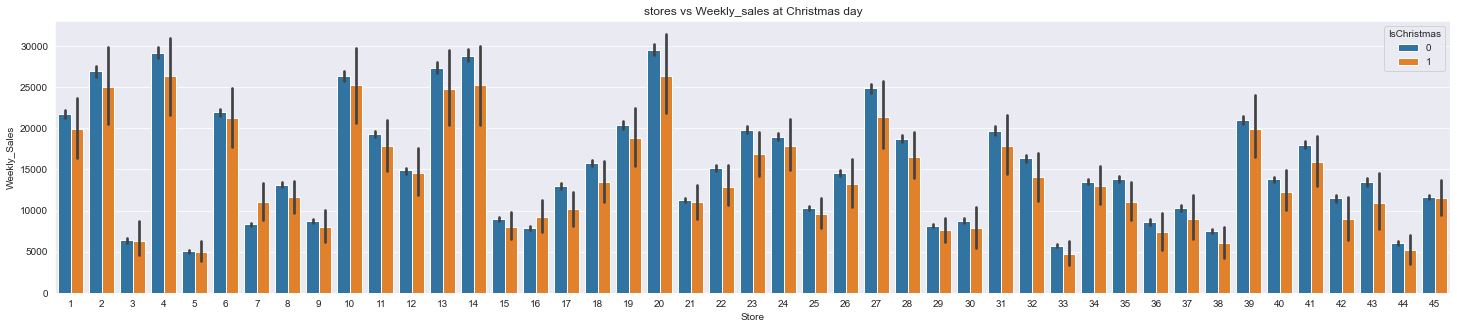

In [37]:

#stores vs Weekly_sales at Christmas day
import seaborn as sns
plt.figure(figsize=(25,5))

sns.barplot(x='Store', y='Weekly_Sales', data=merged_datframe,hue="IsChristmas").set(title='stores vs Weekly_sales at Christmas day')


[Text(0.5, 1.0, 'stores vs Weekly_sales at Christmas day')]

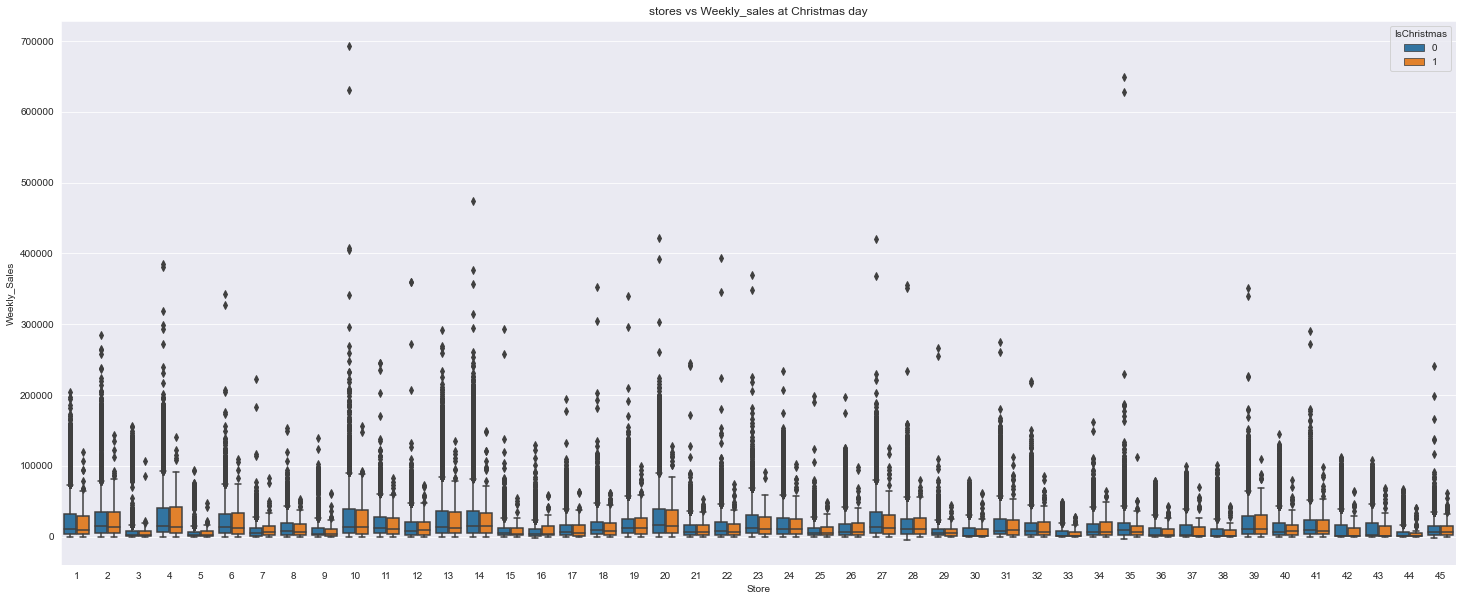

In [30]:

#stores vs Weekly_sales at Christmas day
import seaborn as sns
plt.figure(figsize=(25,10))

sns.boxplot(x='Store', y='Weekly_Sales', data=merged_datframe,hue="IsChristmas").set(title='stores vs Weekly_sales at Christmas day')


We observe that at Christmas day Most of the store's sales values are less then normal days sales values

<h3>observation</h3>
We observe that in all 4 holidays store no (4,20) always have maximum sales and their sales value have always greater then 30 thousnd  and rest of the store have sales values lies under 25 thousand<br>
Whereas Store no (3,5) have always lowest sle and their sales values always lies under 5 thousand.<br>
We Also observe thanksgiving day and superbowl day are the important holidays becuase on these 2 holidays most of the store's sales values are greater then normal days



<h3>Bivariate Analysis

[Text(0.5, 1.0, 'Holidays vs Weekly_sales ')]

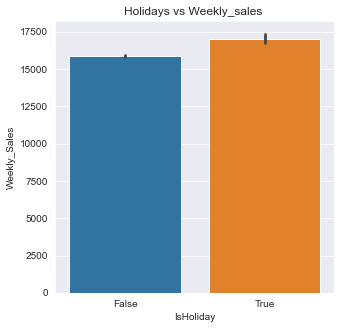

In [13]:
#Holiday vs weekely sales
import seaborn as sns
plt.figure(figsize=(5,5))

sns.barplot(x='IsHoliday', y='Weekly_Sales', data=merged_datframe).set(title='Holidays vs Weekly_sales ')

We observe that at holidays ,stores have highest sales then non holiday

[Text(0.5, 1.0, 'Year vs Weekly_sales ')]

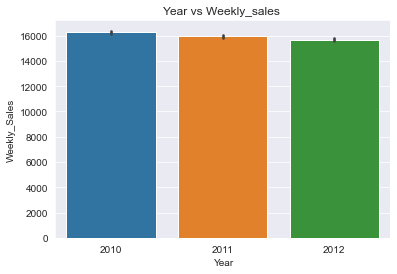

In [18]:
#year wise sales
import seaborn as sns

sns.barplot(x='Year', y='Weekly_Sales', data=train).set(title='Year vs Weekly_sales ')

Here we can observe that from all of the three years, 2010 year have maximum sales values

[Text(0.5, 1.0, 'Store vs Weekly_sales')]

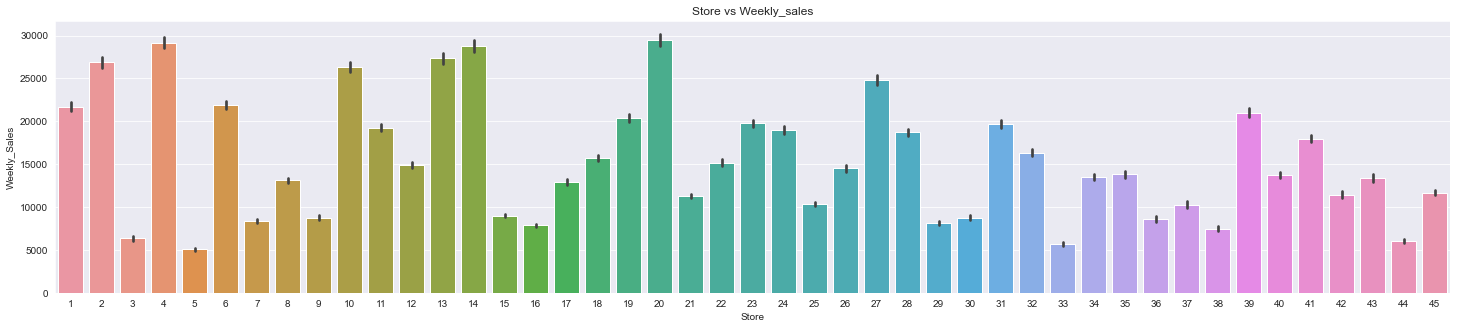

In [42]:
#Store vs Weekly_sales
plt.figure(figsize=(25,5))
sns.barplot(x='Store', y='Weekly_Sales' ,data=train).set(title='Store vs Weekly_sales')

Here we plot given weekly sale vs store and we can observe that most of the stores weekely sales value are greater then 5 thousand less then 30 thousand

[Text(0.5, 1.0, 'Store vs Monthly_Sales_min ')]

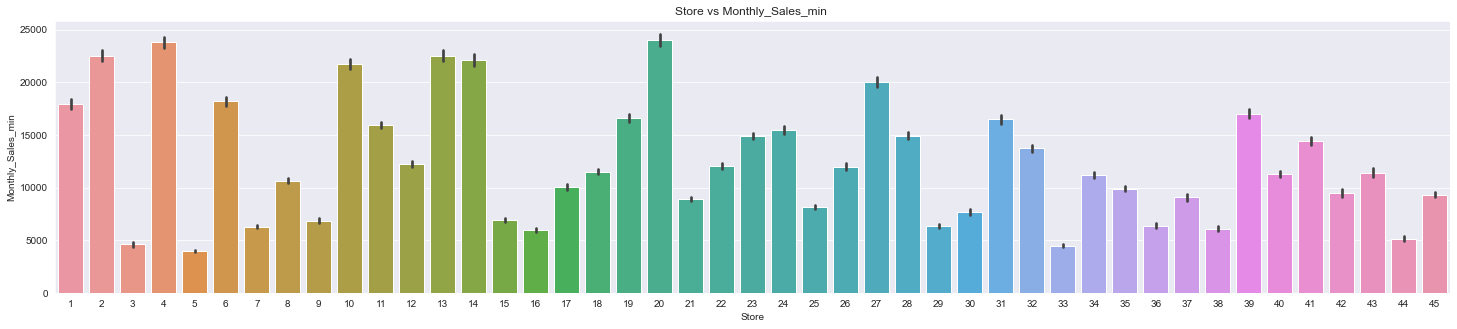

In [43]:
#Store vs Monthly_Sales_min
plt.figure(figsize=(25,5))
sns.barplot(x='Store', y='Monthly_Sales_min' ,data=train).set(title='Store vs Monthly_Sales_min ')

Here we are plotting store vs monthly_minimum_sales .we get monthly_minimum_sales feature by doing feature engineering and after plot,we can observe that only (3,5,33) are the store numbers whose sales is minimum and and their sales values are less then 5000

[Text(0.5, 1.0, ' stores vs monthly_sales_max ')]

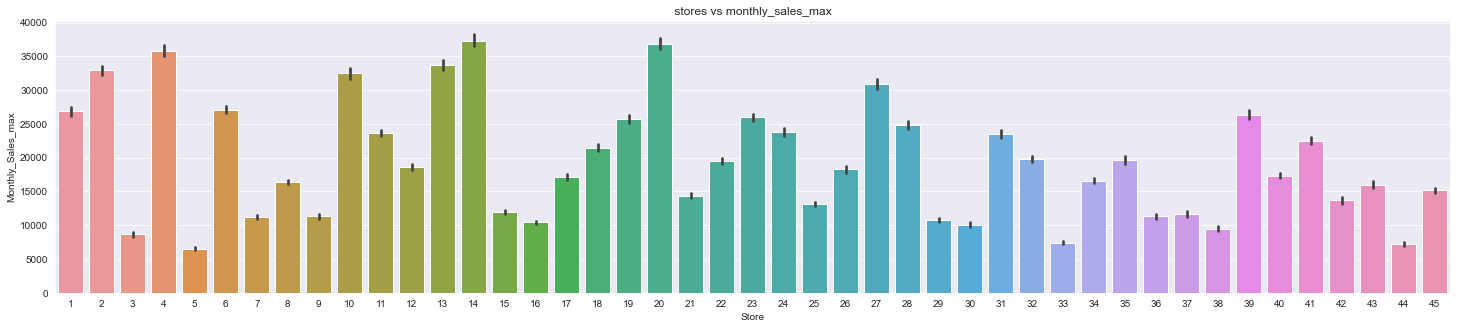

In [44]:
#stores vs monthly_sales_max
plt.figure(figsize=(25,5))
sns.barplot(x='Store', y='Monthly_Sales_max' ,data=train).set(title=' stores vs monthly_sales_max ')


Here we are plotting store vs monthly_max_sale(FE) we can observe that only (4,14,20) are the store numbers whose sales is maximum and greater then 35000 rest of the stores number have sales less then 30000.

[Text(0.5, 1.0, ' Stores vs Monthly_Sales_mean ')]

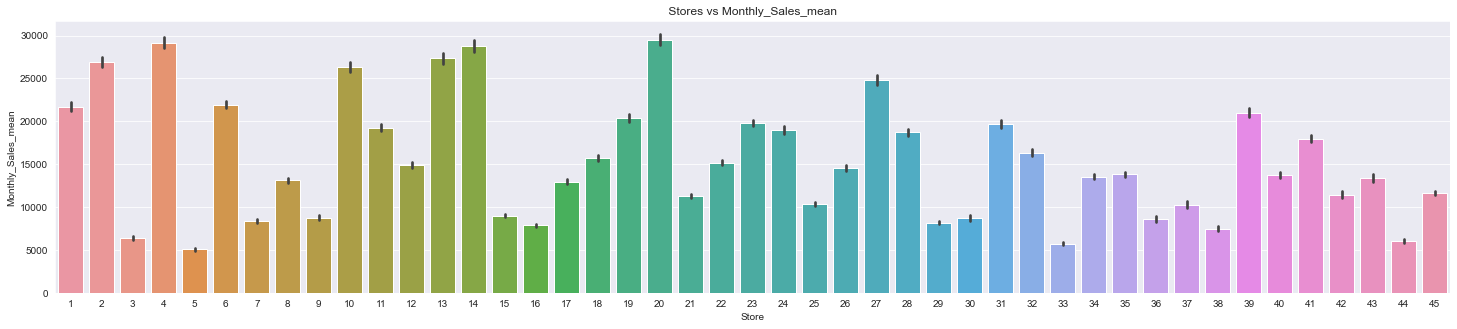

In [45]:
#Stores vs Monthly_Sales_mean
plt.figure(figsize=(25,5))
sns.barplot(x='Store', y='Monthly_Sales_mean' ,data=train).set(title=' Stores vs Monthly_Sales_mean ')

Here we can observe that maximum mean sale value is 30 thousand and there is only one store that touch this max mean value.and there are only 7 stores whose mean value of sale is greater then 25 thousand ,rest of the stores values lies less then 25 thousand mean sale value

[Text(0.5, 1.0, 'Dept vs Weekly_sales')]

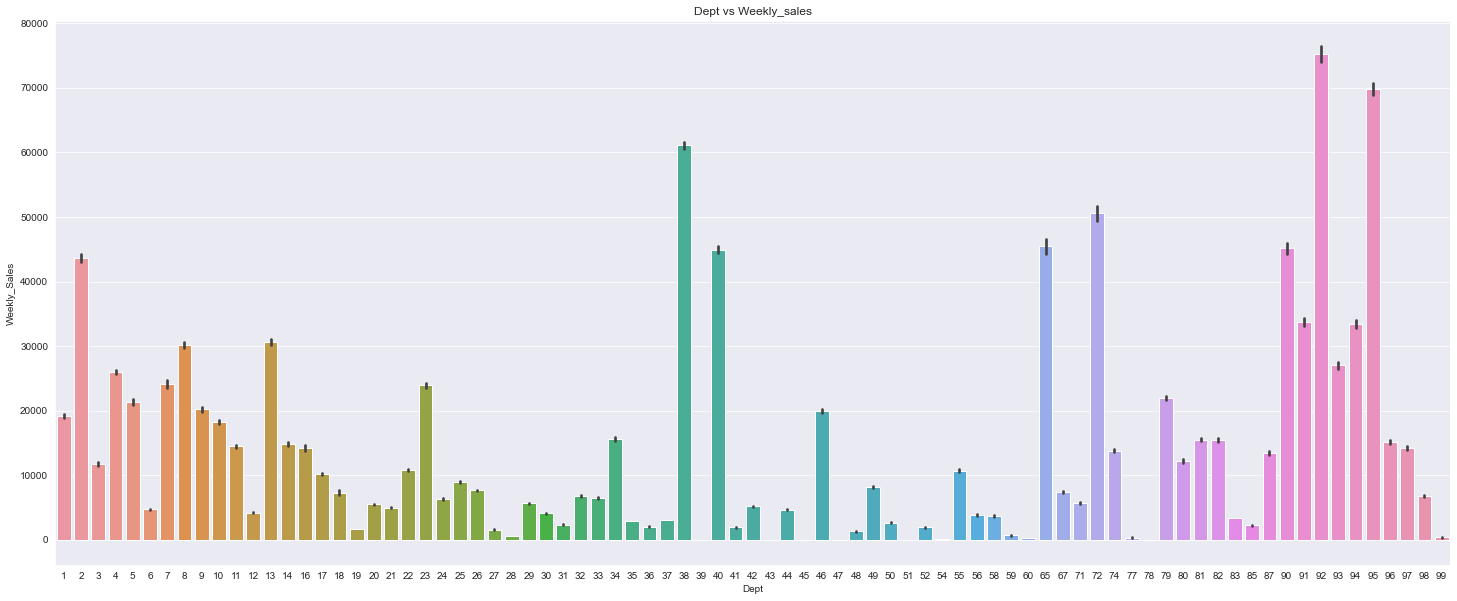

In [46]:
#Dept vs Weekly_sales
plt.figure(figsize=(25,10))
sns.barplot(x='Dept', y='Weekly_Sales' ,data=train).set(title='Dept vs Weekly_sales')

Here we can observe that some  of the Department have sales less then 1000 and their is only one departement(departement no 92) whose sale value is greater then 60 thousand

[Text(0.5, 1.0, ' Stores vs Weekly_Sales ')]

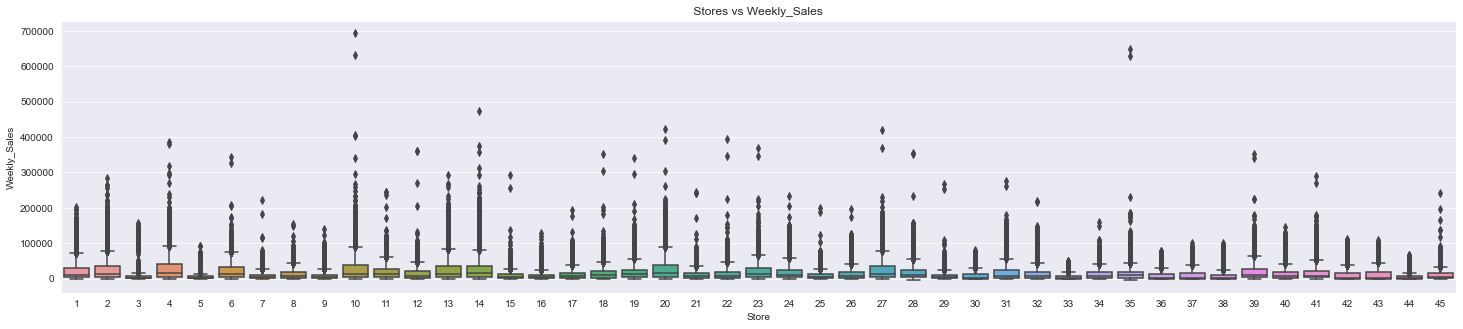

In [47]:
#box  plot of weekely sales vs stores
plt.figure(figsize=(25,5))
sns.boxplot(x="Store", y="Weekly_Sales", data=train).set(title=' Stores vs Weekly_Sales ')

Here we can observe that 10 and 35 store number have some outliers and most of the store have 75% sales under 3000

[Text(0.5, 1.0, ' Dept vs Monthly_Sales_mean ')]

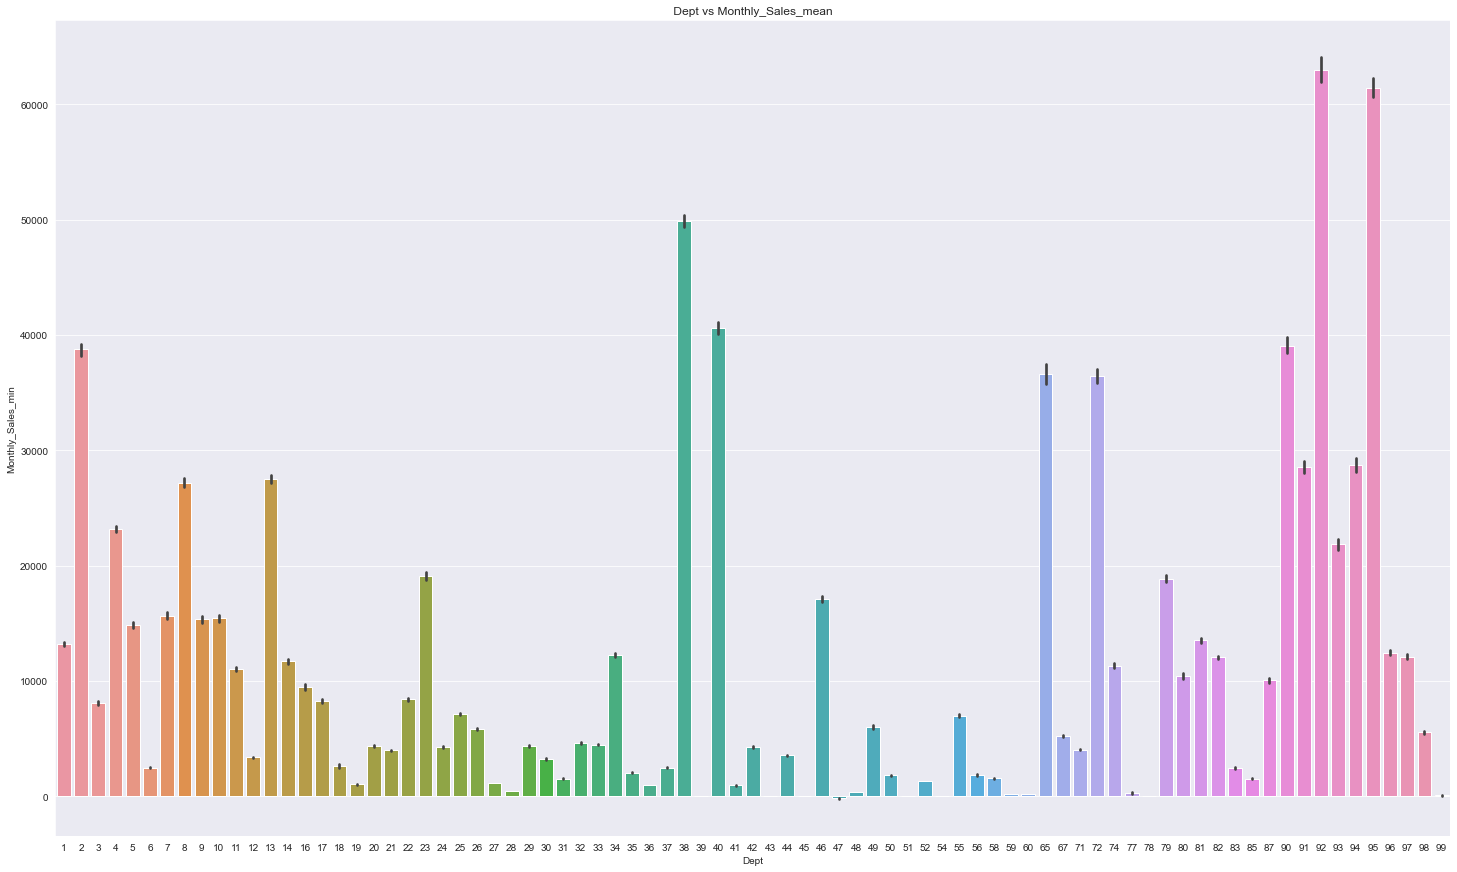

In [51]:
#Bar plot of  Dept vs Monthly_Sales_mean
plt.figure(figsize=(25,15))
sns.barplot(x='Dept', y='Monthly_Sales_min' ,data=train).set(title=' Dept vs Monthly_Sales_mean ')

Here we can observe that there are some departement whose sales is under 1 thousand

<h3>Observation</h3>
After plotting all store type vs monthly minimum and maximum sales we observe that store type is important features for predicting sales values because sales values varies according to store type

[Text(0.5, 1.0, ' Month vs Monthly_sales_max')]

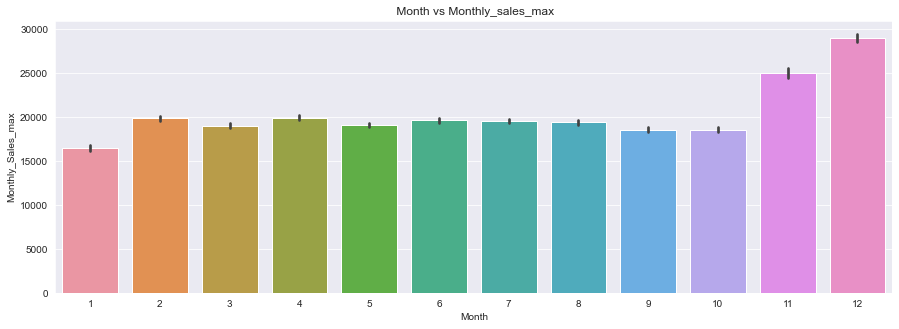

In [32]:
#bar plot of max monthly sale 
plt.figure(figsize=(15,5))
sns.barplot(x='Month', y='Monthly_Sales_max' ,data=train).set(title=' Month vs Monthly_sales_max')

Here we can observe that last 2 Months(11,12) have highest sale and their sale values greater then 25000 and rest of the sales value is approx 20000 or less then 20000,this feature will help stores owner that they need to give more availability of products in that 2 months

[Text(0.5, 1.0, ' Month vs Minimum_Month_sales')]

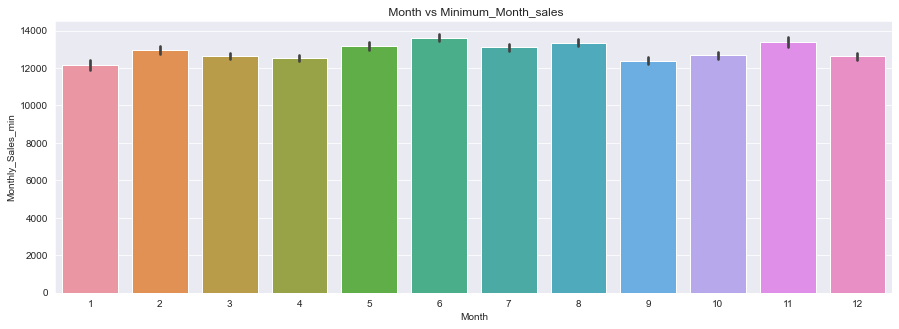

In [31]:
#minumm sales month wise
plt.figure(figsize=(15,5))
sns.barplot(x='Month', y='Monthly_Sales_min' ,data=train).set(title=' Month vs Minimum_Month_sales')

#Here we can observe that Month 1 have lowest sale

[Text(0.5, 1.0, ' Week vs minimum_monthly_sales')]

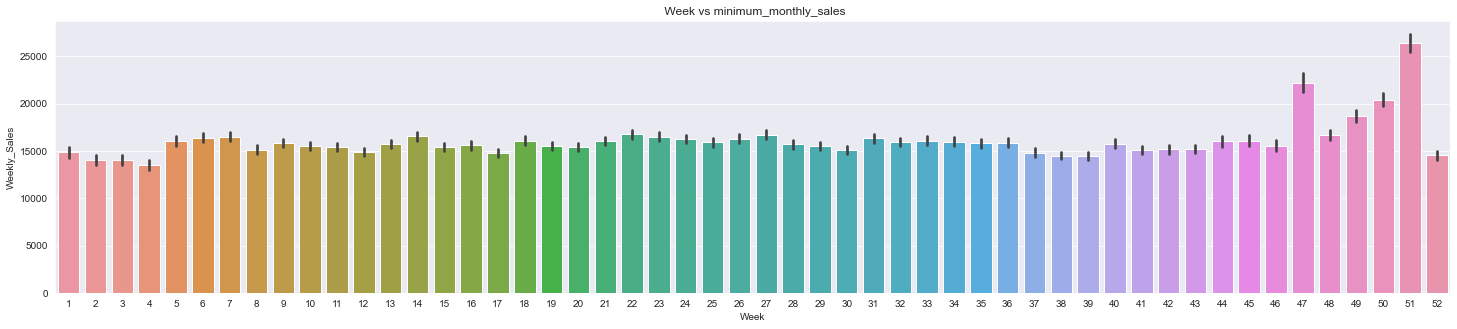

In [49]:
#Week vs minimum_monthly_sales
plt.figure(figsize=(25,5))
sns.barplot(x='Week', y='Weekly_Sales' ,data=train).set(title=' Week vs minimum_monthly_sales')

here we try to find in all months which week have minimum sales .As we saw in previous plot that 1st month have lowest sale ,and we observe that in first month only 4th week have lowest sales .<br>
similarly we observe in previous plot last 2 months have highest sale and we observe that in that 2 month only week number 46 and 52 have lowest sale and week number 47 and 51 have highest sales

<h3> Observation</h3>
After plotting week and month vs monthly_min,monthly_max sales we observe that month and weeks are important factors for predicting sales values

[Text(0.5, 1.0, ' IsSuperbowl vs Weekly_Sales')]

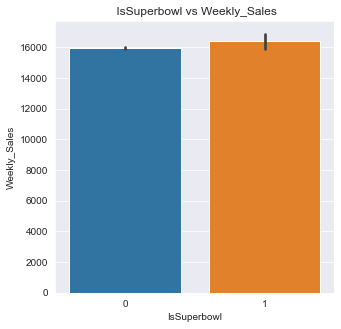

In [20]:
plt.figure(figsize=(5,5))
sns.barplot(x='IsSuperbowl', y='Weekly_Sales' ,data=train).set(title=' IsSuperbowl vs Weekly_Sales')

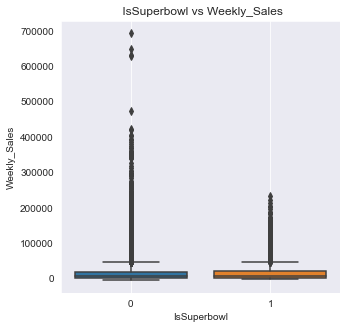

In [22]:
plt.figure(figsize=(5,5))

sns.boxplot(x='IsSuperbowl', y='Weekly_Sales' ,data=train).set(title=' IsSuperbowl vs Weekly_Sales')
plt.grid()

After plotting bar graph and box plot between superbowl vs weekely sales we observe that at IsSuperbowl day their sales is approximately little bit maximum if we compare other days.at superbowl day their sale is more then 16000 whereas another days their sale is under 16000

[Text(0.5, 1.0, ' IsThanksgiving vs Weekly_Sales')]

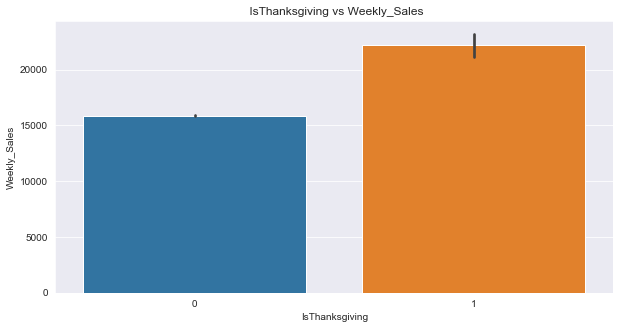

In [23]:
plt.figure(figsize=(10,5))
sns.barplot(x='IsThanksgiving', y='Weekly_Sales' ,data=train).set(title=' IsThanksgiving vs Weekly_Sales')

[Text(0.5, 1.0, ' IsThanksgiving vs Weekly_Sales')]

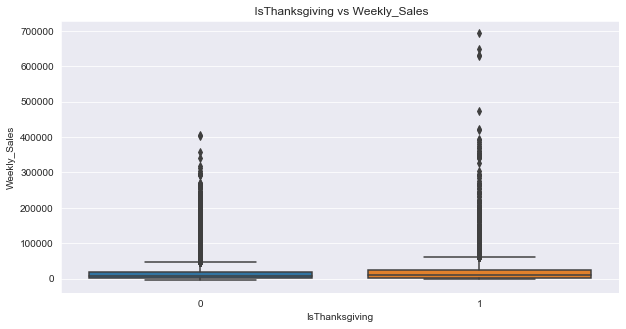

In [26]:
plt.figure(figsize=(10,5))
sns.boxplot(x='IsThanksgiving', y='Weekly_Sales' ,data=train).set(title=' IsThanksgiving vs Weekly_Sales')

we observe that at Thanksgiving  day their sales is maximum then other day ,at that day their sales goes more then 20000,whereas on other day their sales value is under 16000

[Text(0.5, 1.0, 'IsLaborday vs Weekly_Sales')]

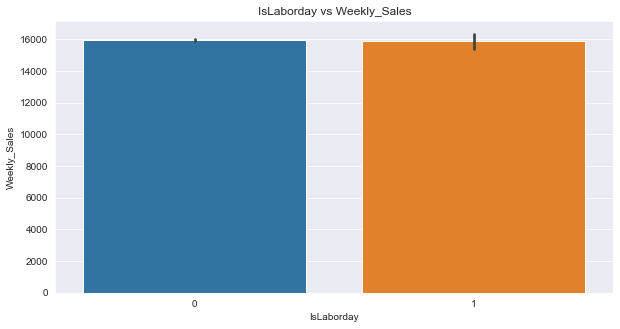

In [25]:
plt.figure(figsize=(10,5))
sns.barplot(x='IsLaborday', y='Weekly_Sales' ,data=train).set(title='IsLaborday vs Weekly_Sales')


[Text(0.5, 1.0, ' IsLaborday vs Weekly_Sales')]

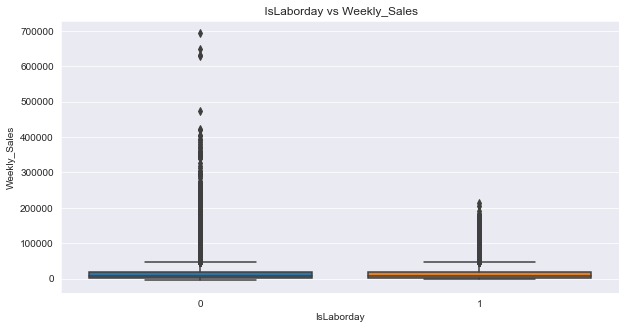

In [24]:
plt.figure(figsize=(10,5))
sns.boxplot(x='IsLaborday', y='Weekly_Sales' ,data=train).set(title=' IsLaborday vs Weekly_Sales')

Here we observe that at labourday day their sales is little bit maximum .at that days their sales values look like normal days

[Text(0.5, 1.0, ' IsChristmas vs Monthly_Sales_max')]

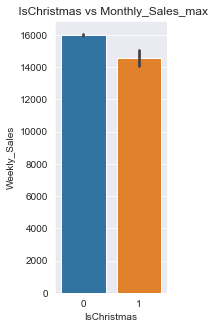

In [19]:
plt.figure(figsize=(2,5))
sns.barplot(x='IsChristmas', y='Weekly_Sales' ,data=train).set(title=' IsChristmas vs Monthly_Sales_max')

[Text(0.5, 1.0, ' IsChristmas vs Monthly_Sales_max')]

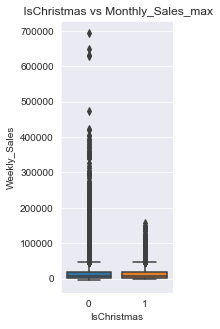

In [25]:
plt.figure(figsize=(2,5))
sns.boxplot(x='IsChristmas', y='Weekly_Sales' ,data=train).set(title=' IsChristmas vs Monthly_Sales_max')

Here we observe that at christmas day their sales value is under 15000 

<h3>Observation</h3>
After plotting all special holidays vs weekely sales ,we observe that at holidays their is maximum sales ,In all 4 holidays at  thanxgiving day their sale is higher then rest of the 3 holidays ,so we can say holidays are the important features for predicting sales values

<h1>Conclusion</h1>
1. most of the stores have weekely sales values under 16000<br>
2. At holidays their sales values is higeher then non holidays<br>
3. At holidays and no holidays From all the stores only store no(4,14,20) have highest sales then other stores,whereas store no (5,33,44) have lower sales<br>
4. At holidays and non holidays store type A have higer sales then store type B and store type C <br>
5. From all the stores Average sales value of store no(4,14,20) is higher then other stores whereas store o (5,33,44) have lower average sales<br>
6. From all months only november and december month have highest sales whereas in first month have lowest sales<br>
7. From all the weeks only 47 and 51 week have highest sales where in 4 week have lowest sales.<br>
8. From all given 4 holidays only thanxgiving day have highest sales if we compare with remaining 3 holidays christmas_day, labours_day,superbowl_day.<br>
9. Thanksgiving day and superbowl day are the important holidays becuase on these 2 holidays most of the store's sales values are greater then normal day's sales values
